# Read and Write Mesh Data

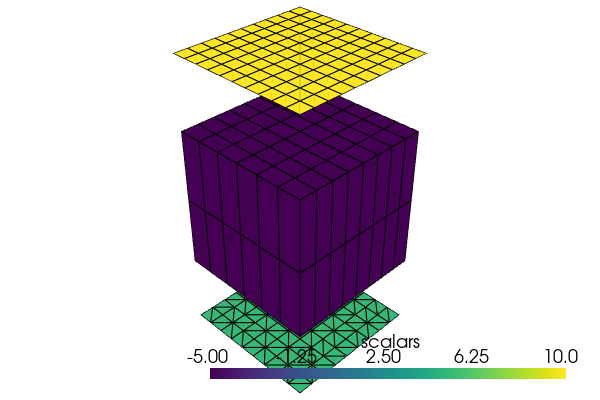

In [1]:
from polymesh import PolyData
from polymesh.trimesh import TriMesh
from polymesh.grid import Grid
from polymesh.space import StandardFrame
import numpy as np

A = StandardFrame(dim=3)
tri = TriMesh(size=(100, 100), shape=(10, 10), frame=A)
grid2d = Grid(size=(100, 100), shape=(10, 10), eshape='Q4', frame=A)
grid3d = Grid(size=(100, 100, 100), shape=(8, 6, 2), eshape='H8', frame=A)

mesh = PolyData(frame=A)
mesh['tri', 'T3'] = tri.move(np.array([0., 0., -50]))
mesh['grids', 'Q4'] = grid2d.move(np.array([0., 0., 150]))
mesh['grids', 'H8'] = grid3d

mesh['tri', 'T3'].pointdata['values'] = np.full(tri.coords().shape[0], 5.)
mesh['grids', 'Q4'].pointdata['values'] = np.full(
    grid2d.coords().shape[0], 10.)
mesh['grids', 'H8'].pointdata['values'] = np.full(
    grid3d.coords().shape[0], -5.)

mesh.to_standard_form()
mesh.lock(create_mappers=True)

mesh.pvplot(notebook=True, window_size = (600, 400), 
            jupyter_backend='static', scalars=mesh.pd['values'].to_numpy())

In [2]:
mesh.pd.to_parquet("pd.parquet")
mesh['tri', 'T3'].cd.to_parquet("cdT3.parquet")
mesh['grids', 'Q4'].cd.to_parquet("cdQ4.parquet")
mesh['grids', 'H8'].cd.to_parquet("cdH8.parquet")
paths = ["pd.parquet", "cdT3.parquet", "cdQ4.parquet", "cdH8.parquet"]

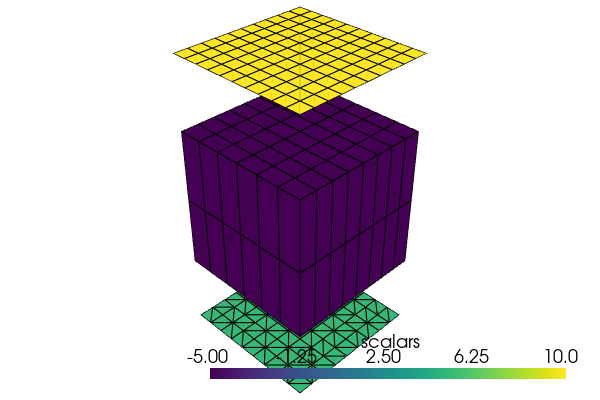

In [3]:
from polymesh.cells import T3, Q4, H8
from polymesh import PointData

frame=StandardFrame(dim=3)

pd = PointData.from_parquet("pd.parquet")
mesh = PolyData(pd, frame=frame)

cdT3 = T3.from_parquet("cdT3.parquet")
mesh['tri', 'T3'] = PolyData(cdT3, frame=frame)

cdQ4 = Q4.from_parquet("cdQ4.parquet")
mesh['grids', 'Q4'] = PolyData(cdQ4, frame=frame)

cdH8 = H8.from_parquet("cdH8.parquet")
mesh['grids', 'H8'] = PolyData(cdH8, frame=frame)

mesh.to_standard_form()
mesh.lock(create_mappers=True)

mesh.pvplot(notebook=True, window_size = (600, 400), 
            jupyter_backend='static', scalars=mesh.pd['values'].to_numpy())

In [4]:
mesh.to_parquet("mesh_pd.parquet", "mesh_cd.parquet")
paths.extend(["mesh_pd.parquet", "mesh_cd.parquet"])

In [5]:
df_pd, df_cd = mesh.to_pandas()

In [ ]:
import os
for path in paths:
    if os.path.exists(path):
        os.remove(path)

In [ ]:
from neumann.logical import isclose

A = StandardFrame(dim=3)
tri = TriMesh(size=(100, 100), shape=(10, 10), 
                frame=A)
grid2d = Grid(size=(100, 100), shape=(10, 10), 
                eshape='Q4', frame=A)
grid3d = Grid(size=(100, 100, 100), shape=(8, 6, 2), 
                eshape='H8', frame=A)

mesh = PolyData(frame=A)
mesh['tri', 'T3'] = tri.move(np.array([0., 0., -50]))
mesh['grids', 'Q4'] = grid2d.move(np.array([0., 0., 150]))
mesh['grids', 'H8'] = grid3d

mesh['tri', 'T3'].pointdata['values'] = \
    np.full(tri.coords().shape[0], 5.)
mesh['grids', 'Q4'].pointdata['values'] = np.full(
    grid2d.coords().shape[0], 10.)
mesh['grids', 'H8'].pointdata['values'] = np.full(
    grid3d.coords().shape[0], -5.)

mesh.to_standard_form()
mesh.lock(create_mappers=True)

volume = mesh.volume()

mesh.pd.to_parquet("pd.parquet")
mesh['tri', 'T3'].cd.to_parquet("cdT3.parquet")
mesh['grids', 'Q4'].cd.to_parquet("cdQ4.parquet")
mesh['grids', 'H8'].cd.to_parquet("cdH8.parquet")
paths = ["pd.parquet","cdT3.parquet", "cdQ4.parquet", "cdH8.parquet"]

pd = PointData.from_parquet("pd.parquet")
mesh = PolyData(pd, frame=A)
cdT3 = T3.from_parquet("cdT3.parquet")
mesh['tri', 'T3'] = PolyData(cdT3, frame=A)
cdQ4 = Q4.from_parquet("cdQ4.parquet")
mesh['grids', 'Q4'] = PolyData(cdQ4, frame=A)
cdH8 = H8.from_parquet("cdH8.parquet")
mesh['grids', 'H8'] = PolyData(cdH8, frame=A)

assert isclose(volume, mesh.volume(), atol=1e-5, rtol=None)

mesh.to_standard_form()
t = mesh.topology()
t0 = mesh.coords().shape[0]
imin = np.min(t)
t1 = np.max(t) - imin + 1

assert t0 == t1
assert imin == 0

for path in paths:
    if os.path.exists(path):
        os.remove(path)